# Target Audience for Direct Marketing in Starbucks Rewards Mobile App

This is the last part 4 of Starbucks capstone project. In this part, I put all steps together and check clustering results under different analytical assumptions. 

See `1_Starbucks_cleaning.ipynb`, `2_Starbucks_eda.ipynb` and `3_Starbucks_modeling.ipynb` for more information on earlier steps.

In [ ]:
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from pandas.io.json import json_normalize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Create final DataFrame

In [2]:
def clean_profile_dataset(profile):
    '''
    Input:
        profile: original profile dataset 
    Output:
        profile_clean: cleaned profile dataset
    '''
    profile_clean = profile.copy()  
    # renaming 'id' column to 'person' in profile dataset 
    profile_clean.rename(columns={profile_clean.columns[2]:'person'}, inplace=True)
    #Change type of 'became_member_on' column from int to time:
    profile_clean.became_member_on = pd.to_datetime(profile_clean.became_member_on.astype(str), format="%Y/%m/%d")
    # Replace NoneType with Nans in gender column
    profile_clean.gender.fillna(value=np.nan, inplace=True)
    # Replace 118 with Nans in age column:
    profile_clean.age.replace(118, np.nan, inplace=True)
    
    return profile_clean

In [3]:
def normalize_json_in_transcript_dataset(transcript):
    '''
    Input:
        transcript: original transcript dataset 
    Output:
        transcript_clean: normalized transcript dataset
    '''    
    # normalize json in value column
    value_normalized = json_normalize(transcript['value'])
    # merging the two columns 'offer id' and 'offer_id' into new one 'id'
    value_normalized['id'] = value_normalized['offer id'].fillna(value_normalized['offer_id'])
    # dropping the redundant columns 'offer id', 'offer_id'
    value_normalized = value_normalized.drop(['offer id', 'offer_id'], axis=1)
    #rename the column 'reward' to 'rewarded'
    value_normalized.rename(columns={value_normalized.columns[1]:'rewarded'}, inplace=True)
    # join value_normalized with transcript 
    transcript_clean = transcript.join(value_normalized)    
    # dropping 'value', 'event' columns
    transcript_clean = transcript_clean.drop(['value'], axis=1)
    
    return transcript_clean

In [4]:
def merge_cleaned_datasets(profile, transcript, portfolio):
    '''
    Input:
        profile: original profile dataset
        transcript: original transcript dataset
        portfolio: original portfolio dataset
    Output:
        starbucks_merged: merged dataset with selected columns
    
    '''
    profile_clean = clean_profile_dataset(profile)
    transcript_clean = normalize_json_in_transcript_dataset(transcript)
    
    #combine datasets
    df = profile_clean.merge(transcript_clean, on='person', how='right')
    starbucks_merged = df.merge(portfolio, on='id', how='left')
    
    #one-hot encode 'event' and 'offer_type'
    starbucks_merged = pd.get_dummies(starbucks_merged, columns=['event', 'offer_type'])
    
    # reordering the columns (exclude 'channels', 'difficulty')
    starbucks_merged = starbucks_merged[['person', 'became_member_on', 'age', 'gender', 'income',
                           'time', 'id', 'duration', 'reward', 
                           'amount','rewarded', 
                           'event_offer completed', 'event_offer received', 'event_offer viewed',
                           'event_transaction', 'offer_type_bogo', 'offer_type_discount',
                           'offer_type_informational']]
    
    # renaming the columns
    starbucks_merged.columns = ['person', 'became_member_on', 'age', 'gender', 'income', 
                         'time', 'offer_id', 'offer_duration', 'offer_reward',
                         'amount','rewarded', 'offer_completed', 'offer_received', 'offer_viewed',
                         'transaction', 'bogo', 'discount', 'informational']
    return starbucks_merged

In [5]:
def aggregate_data_at_offers_level(starbucks_merged):
    '''
    Aggregates data at the level of each offer with correctly attributed metrics 
    and information about each offer from portfolio dataset
    Input: 
        starbucks_merged: data frame that resulted from merge_clean_datasets()
    Output:
        offers: data frame aggregated at the offer level with correctly attributed metrics
    '''
    starbucks_time = starbucks_merged[starbucks_merged.transaction == 0][['person', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed', 'time']]
    
    # reencode time=0 with time=0.5 to avoid confusion with 0s after aggregation at later stage
    starbucks_time['time'] = starbucks_time.time.replace(0, 0.5)
    
    #create unique identifier for each offer sent (because same offers could be sent more than once)
    starbucks_time['id_unique_received'] = starbucks_time[starbucks_time.offer_received == 1].groupby(['person', 'offer_id']).cumcount()
    starbucks_time['id_unique_viewed'] = starbucks_time[starbucks_time.offer_viewed == 1].groupby(['person', 'offer_id']).cumcount()
    starbucks_time['id_unique_completed'] = starbucks_time[starbucks_time.offer_completed == 1].groupby(['person', 'offer_id']).cumcount()
    starbucks_time['id_unique_events'] = starbucks_time[['id_unique_received', 'id_unique_viewed', 'id_unique_completed']].max(axis=1).values
    starbucks_time['id_unique'] = starbucks_time['offer_id'] + "-" + starbucks_time['id_unique_events'].apply(lambda x: str(x))

    # create columns with time for each event
    starbucks_time['offer_received_time'] = starbucks_time['offer_received']*starbucks_time.time
    starbucks_time['offer_viewed_time'] = starbucks_time['offer_viewed']*starbucks_time.time
    starbucks_time['offer_completed_time'] = starbucks_time['offer_completed']*starbucks_time.time
    starbucks_time = starbucks_time[['person', 'id_unique', 'offer_id', 'time', 'offer_received_time', 'offer_viewed_time', 'offer_completed_time']]

    # unstack values to get to the level of each (person, offer id) tuple
    # need to take max value to avoid 0s
    starbucks_time_full = starbucks_time.groupby(by=['person', 'id_unique', 'time']).max().unstack()
    starbucks_time_full.fillna(0, inplace=True)

    # create the final time-based dataset for each offer sent
    offers = pd.DataFrame(starbucks_time_full.index.get_level_values('id_unique'), starbucks_time_full.index.get_level_values('person')).reset_index()
    offers['offer_received_time'] = starbucks_time_full['offer_received_time'].values.max(axis=1)
    offers['offer_viewed_time'] = starbucks_time_full['offer_viewed_time'].values.max(axis=1)
    offers['offer_completed_time'] = starbucks_time_full['offer_completed_time'].values.max(axis=1)

    # add information about each offer from portfolio
    offers['id'] = offers.id_unique.apply(lambda x: x.split("-")[0])
    offers = offers.merge(portfolio, on='id', how='left')

    # add offer end time
    offers['offer_end_time'] = offers['offer_received_time']+offers['duration'].values*24
        
    offers['viewed_binary'] = offers.offer_viewed_time.apply(lambda x: 1 if x > 0 else 0)
    # 0 if viewed_time < end_time and 1 otherwise, multiply whether the offer was indeed viewed 
    # (because 0 time is also < end time, but it means that the offer was not viewed!)
    offers['viewed_on_time'] = (offers.offer_viewed_time < offers.offer_end_time)*offers['viewed_binary'] 
    
    offers['completed_binary'] = offers.offer_completed_time.apply(lambda x: 1 if x > 0 else 0)
    offers['completed_on_time'] = (offers.offer_completed_time < offers.offer_end_time)*offers['completed_binary'] 
    
    # correctly attributed completed offers need to meet several conditions:
    # 1. it should be completed before offer end
    completed_before_expires = (offers.offer_completed_time < offers.offer_end_time)
    # 2. it should be completed after viewing 
    completed_after_viewing =(offers.offer_completed_time > offers.offer_viewed_time)*offers['viewed_binary']
    offers['completed_after_viewing'] = (completed_after_viewing & completed_before_expires)*offers['completed_binary']
    
    return offers

In [6]:
def aggregate_data_at_person_level(offers, starbucks_merged):
    '''
    Aggregates data at person level
    Input: 
        offers: data frame resulted from calling aggregate_data_at_offers_level()
    Output:
        starbucks_aggr: data frame with aggregated data at person level and correctly attributed metrics
    '''    
    offers_by_person = pd.DataFrame(offers.groupby('person').id_unique.count())
    offers_by_person.columns = ['offers_received']
    offers_by_person['offers_viewed'] = pd.Series(offers.groupby('person').viewed_on_time.sum())
    offers_by_person['offers_completed'] = pd.Series(offers.groupby('person').completed_after_viewing.sum())
    offers_by_person['offers_rr'] = offers_by_person.offers_viewed/offers_by_person.offers_received
    offers_by_person['offers_cvr'] = offers_by_person.offers_completed/offers_by_person.offers_viewed
    
    # BOGO received number 
    cond_correct = (offers.offer_type == 'bogo')
    bogo_received = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(bogo_received, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'bogo_received'}, inplace=True)
    
    # CORRECTLY attributed BOGO viewed number 
    cond_correct = (offers.offer_type == 'bogo') & (offers.viewed_on_time == 1) 
    bogo_viewed = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(bogo_viewed, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'bogo_viewed'}, inplace=True)

    # CORRECTLY attributed BOGO amount (completed after viewing)
    cond_correct = (offers.offer_type == 'bogo') & (offers.completed_after_viewing == 1) 
    total_bogo = offers[cond_correct].groupby(by='person').reward.sum()
    offers_by_person = offers_by_person.merge(total_bogo, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'total_bogo'}, inplace=True)

    # CORRECTLY attributed BOGO comleted number (completed after viewing)
    bogo = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(bogo, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'bogo_completed'}, inplace=True)
    
    # DISCOUNT received number 
    cond_correct = (offers.offer_type == 'discount')
    discount_received = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(discount_received, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'discount_received'}, inplace=True)

    # CORRECTLY attributed DISCOUNT viewed number 
    cond_correct = (offers.offer_type == 'discount') & (offers.viewed_on_time == 1) 
    discount_viewed = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(discount_viewed, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'discount_viewed'}, inplace=True)

    # CORRECTLY attributed DISCOUNT amount (completed after viewing)
    cond_correct = (offers.offer_type == 'discount') & (offers.completed_after_viewing == 1) 
    total_bogo_corr = offers[cond_correct].groupby(by='person').reward.sum()
    offers_by_person = offers_by_person.merge(total_bogo_corr, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'total_discount'}, inplace=True)

    # CORRECTLY attributed DISCOUNT completed number (completed after viewing)
    discount = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(discount, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'discount_completed'}, inplace=True)
    
    # INFORMATIONAL received number 
    cond_correct = (offers.offer_type == 'informational')

    informational_received = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(informational_received, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'informational_received'}, inplace=True)

    # CORRECTLY attributed INFORMATIONAL viewed number (viewed on time)
    cond_correct = ((offers.offer_type == 'informational') & (offers.viewed_on_time == 1))

    informational = offers[cond_correct].groupby(by='person')['id_unique'].count()
    offers_by_person = offers_by_person.merge(informational, on='person', how='left')
    offers_by_person.rename(columns={offers_by_person.columns[-1]:'informational_viewed'}, inplace=True)
    
    # CORRECT AMOUNT REWARDED
    cond_corr = (offers.completed_after_viewing == 1)
    offers_by_person['total_rewarded'] = pd.DataFrame(offers[cond_corr].groupby('person').reward.sum())

    offers_by_person['bogo_rr'] = offers_by_person.bogo_viewed/offers_by_person.bogo_received
    offers_by_person['bogo_cvr'] = offers_by_person.bogo_completed/offers_by_person.bogo_viewed
    offers_by_person['discount_rr'] = offers_by_person.discount_viewed/offers_by_person.discount_received
    offers_by_person['discount_cvr'] = offers_by_person.discount_completed/offers_by_person.discount_viewed
    offers_by_person['informational_rr'] = offers_by_person.informational_viewed/offers_by_person.informational_received
    
    offers_by_person = offers_by_person.fillna(0)
    
    #merge with profile info
    profile_clean = clean_profile_dataset(profile)
    starbucks_aggr = profile_clean.merge(offers_by_person, on='person', how='left')
    
    # fill NaNs in all columns except age, income, gender with 0s for 6 people without offers
    cols_notprofile = starbucks_aggr.columns.difference(['age', 'income', 'gender'])
    starbucks_aggr[cols_notprofile] = starbucks_aggr[cols_notprofile].fillna(0)
    
    #add spending information    
    spending = starbucks_merged.groupby('person')[['amount', 'transaction']].sum()
    starbucks_aggr = starbucks_aggr.merge(spending, on='person', how='left')
    starbucks_aggr.rename(columns={starbucks_aggr.columns[-1]:'transactions_num'}, inplace=True)
    starbucks_aggr.rename(columns={starbucks_aggr.columns[-2]:'total_amount'}, inplace=True)
    
    #reorder columns
    starbucks_aggr = starbucks_aggr[['gender', 'age', 'person', 'became_member_on', 'income', 'total_amount',
                                 'total_rewarded', 'transactions_num', 'offers_received', 
                                 'offers_viewed', 'offers_completed',
                                'bogo_received', 'bogo_viewed', 'bogo_completed',
                                'discount_received', 'discount_viewed', 'discount_completed',
                                'informational_received', 'informational_viewed',
                                'total_bogo', 'total_discount']]
    return starbucks_aggr

In [7]:
def engineer_new_features(starbucks_aggr):
    '''
    Engineers new features based on data that we already have
    Input:
        starbucks_aggr: data frame resulted from calling aggregate_data_at_person_level()
    Output:
        starbucks_engineered: the same data frame with new features added
    '''    
    starbucks_engineered = starbucks_aggr.copy()
    
    # reencode became_member_on as membership by years in str format (categorical)
    starbucks_engineered['became_member_on'] = starbucks_engineered.became_member_on.apply(lambda x: str(x.year))    
    
    # create 4 new columns:
    starbucks_engineered['avg_order_size'] = round(starbucks_engineered['total_amount']/starbucks_engineered['transactions_num'], 2)
    # when there were no transactions, avg_order_size was converted to NaNs, replace these with 0:
    starbucks_engineered['avg_order_size'] = starbucks_engineered['avg_order_size'].replace(np.nan, 0)

    starbucks_engineered['avg_reward_size'] = round(starbucks_engineered['total_rewarded']/starbucks_engineered['offers_completed'], 2)
    # when there were no offers completed, avg_reward_size was converted to NaNs, replace these with 0:
    starbucks_engineered['avg_reward_size'] = starbucks_engineered['avg_reward_size'].replace(np.nan, 0)

    # average bogo size and average discount size
    for each in ['bogo', 'discount']:
        starbucks_engineered['avg_'+each+'_size'] = round(starbucks_engineered['total_'+each]/starbucks_engineered[each+'_completed'], 2)
        starbucks_engineered['avg_'+each+'_size'] = starbucks_engineered['avg_'+each+'_size'].replace(np.nan, 0)        
    
    # create new columns with CVR and RR for each offer type
    for each in ['offers', 'bogo', 'discount', 'informational']:
        # reponse rate, % offers viewed to offers received
        starbucks_engineered[each+'_rr'] = round(starbucks_engineered[each+'_viewed']/starbucks_engineered[each+'_received'] * 100, 2)
        # replace div by 0 - if no offers received, then rr = 0
        starbucks_engineered[each+'_rr'] = starbucks_engineered[each+'_rr'].replace(np.nan, 0).replace(np.inf, 0)

        # conversion rate, % offers completed to offers viewed
        if each != 'informational':
            starbucks_engineered[each+'_cvr'] = round(starbucks_engineered[each+'_completed']/starbucks_engineered[each+'_viewed'] * 100, 2)
            # replace div by 0 - if no offers viewed, then cvr = 0
            starbucks_engineered[each+'_cvr'] = starbucks_engineered[each+'_cvr'].replace(np.inf, 0).replace(np.nan, 0)        
    
    return starbucks_engineered

In [8]:
def deal_with_missing_values(starbucks_engineered, how='impute'):
    '''
    Input:
        starbucks_engineered: dataframe that resulted from engineer_new_features()
        how: 
            'impute' with median values, 
            'drop' missing values 
    Output:
        starbucks_imputed: data frame without missing values
    '''
    starbucks_imputed = starbucks_engineered.copy()

    if how == 'impute':
        imputer = SimpleImputer(strategy='median')
        imputed = imputer.fit_transform(starbucks_engineered[['age', 'income']])
        starbucks_imputed[['age', 'income']] = pd.DataFrame(imputed, columns=['age', 'income'])
        values = {'gender': starbucks_engineered.gender.mode()[0]}
        starbucks_imputed.fillna(value=values, inplace=True)
        
    if how == 'drop':
          starbucks_imputed.dropna(axis=0, inplace=True)
    
    return starbucks_imputed

# Generate Report:

In [9]:
def create_segments(df, cluster_num=5, do_minmax=False, do_pca=True, generate_report=True):
    '''
    Creates cluster segments and generates report
    Input:
        df: the final dataset that is ready for clustering (e.g. starbucks_imputed)
        cluster_num: number of clusters to be created
        do_minmax (bool): flag condition to use MinMax Scaler if True, otherwise use Standard Scaler
        do_pca (bool): flag condition to perfom PCA if True
        generate_report (bool): whether to generate report 
                                (i.e. plot segments interpreter, customer segments by size, metrics)
    '''
    #one-hot encoding
    starbucks_ohe = df.copy()
    starbucks_ohe.drop('person', axis=1, inplace=True)
    categorical_col = starbucks_ohe.columns[(starbucks_ohe.dtypes == 'category') | (starbucks_ohe.dtypes == 'object')]
    starbucks_ohe = pd.get_dummies(starbucks_ohe, columns=categorical_col)
    
    # feature scaling
    if do_minmax == False:
        scaler = StandardScaler().fit(starbucks_ohe)
    else:
        scaler = MinMaxScaler().fit(starbucks_ohe)
    starbucks_scaled = scaler.transform(starbucks_ohe) 

    # PCA
    if do_pca == True:
        pca = PCA()
        X_pca = pca.fit_transform(starbucks_scaled)
        cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)

        #choose number of components that explain ~80% of variance
        components_num = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.805])
        print(f"number of pca components that explain 80%: {components_num}")
        pca = PCA(components_num).fit(starbucks_scaled)
        starbucks_pca = pca.transform(starbucks_scaled)
    
        # clustering
        clusterer = KMeans(n_clusters=cluster_num, n_init=10, init='k-means++').fit(starbucks_pca)
        starbucks_preds = clusterer.predict(starbucks_pca)
        print(f"silhouette_score for {cluster_num} clusters: {metrics.silhouette_score(starbucks_pca, clusterer.labels_, metric='euclidean'):.3f}")
        print(82 * '_')
        plot_elbow_curve(starbucks_pca)
        
    else:
        pca = None
        starbucks_pca = None
        # clustering
        clusterer = KMeans(n_clusters=cluster_num, n_init=10, init='k-means++').fit(starbucks_scaled) 
        starbucks_preds = clusterer.predict(starbucks_scaled)
        print("silhouette_score:", metrics.silhouette_score(starbucks_scaled, clusterer.labels_, metric='euclidean'))
        print(82 * '_')
        plot_elbow_curve(starbucks_scaled)
    
    # assign customer segments to data
    starbucks_predicted = df.copy()
    starbucks_predicted['segments'] = starbucks_preds
     
    #generate report
    if generate_report == True:
        cluster_df = create_cluster_df(pca, clusterer, scaler, cluster_num, starbucks_ohe, do_minmax, do_pca)
        plot_segments_interpreter(cluster_df)
        plot_customer_segments(starbucks_predicted, cluster_num)
        plot_metrics(starbucks_predicted)
        
    #return starbucks_ohe, scaler, starbucks_scaled, pca, starbucks_pca, clusterer, starbucks_preds
    return starbucks_predicted

In [10]:
def plot_elbow_curve(df):
    '''
    Plots elbow curve for identifying optimal k clusters
    Input:
        df: e.g. starbucks_pca or starbucks_scaled
    Output:
        None
    '''
    plt.figure(figsize=(8, 4));
    
    range_n_clusters = [2, 3, 5, 8, 10]
    sum_of_squared_distances = []
    since = time.time()

    for n_clusters in range_n_clusters:
        cluster_start = time.time()
        print(f"{n_clusters} clusters:")
        # run k-means clustering on the data and...
        clusterer = KMeans(n_clusters=n_clusters, random_state=120).fit(df)
        print(f"   silouhette score: {metrics.silhouette_score(df, clusterer.labels_, metric='euclidean'):.3f}")

        # ... compute the average within-cluster distances.
        sum_of_squared_distances.append(clusterer.inertia_)
        print(f"   sum of squared distances: {clusterer.inertia_:.1f}")
        #print("time for this cluster:", time.time() - cluster_start)

    time_elapsed = time.time() - since
    print('Clustering complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    plt.plot(range_n_clusters, sum_of_squared_distances)
    plt.xlabel('Number of Clusters')
    plt.xticks(range_n_clusters, range_n_clusters)
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method for Optimal k')
    plt.grid();
    print(80*"-")

In [11]:
def interpret_cluster(pca, clusterer, scaler, cluster_num, df, do_minmax, do_pca):
    '''
    Performs inversing the results of PCA and Scaler to allow cluster interpretation
    Input:
        cluster_num: number of clusters that were used to perform clustering
        df: data frame used for clustering
        minmax (bool): condition whetherminmax scaler was used 
    Output:
        results_df: data frame with inversed values for one cluster                
    '''
    if do_pca == True:
        pca_inversed = pca.inverse_transform(clusterer.cluster_centers_[cluster_num, :])
    
        if do_minmax == True:
            scaler_inversed = np.around(scaler.inverse_transform(pca_inversed.reshape(1, -1)), decimals=2)
            results_df = pd.DataFrame(scaler_inversed.ravel(), df.columns)
        else:
            scaler_inversed = np.around(scaler.inverse_transform(pca_inversed), decimals=2)
            results_df = pd.DataFrame(scaler_inversed, df.columns)
    else:
        if do_minmax == True:
            scaler_inversed = np.around(scaler.inverse_transform(clusterer.cluster_centers_[cluster_num, :].reshape(1, -1)), decimals=2)
            results_df = pd.DataFrame(scaler_inversed.ravel(), df.columns)
        else:
            scaler_inversed = np.around(scaler.inverse_transform(clusterer.cluster_centers_[cluster_num, :]), decimals=2)
            results_df = pd.DataFrame(scaler_inversed, df.columns)            
            
    return results_df

In [12]:
def create_cluster_df(pca, clusterer, scaler, cluster_num, df, do_minmax=False, do_pca=True):
    '''
    Creates results dataframe for all clusters and compares them with mean values across each column
    Input:
        cluster_num: number of clusters that were used to perform clustering
        df: data frame used for clustering
        minmax (bool): condition whetherminmax scaler was used 
    Output:
        results_df: data frame with cluster results for all clusters                
    '''    
    cluster_df = pd.DataFrame(interpret_cluster(pca, clusterer, scaler, 0, df, do_minmax, do_pca))
    cluster_df.drop(0, axis=1, inplace=True)

    for i in range(cluster_num):
        cluster_df['cluster_'+str(i+1)] = interpret_cluster(pca, clusterer, scaler, i, df, do_minmax, do_pca)
    means = []
    for each in df.columns:
        mean = round(df[each].mean(), 2)
        means.append(mean)
    means_df = pd.DataFrame(means, index=cluster_df.index, columns=['means'])
    cluster_df_fin = cluster_df.merge(means_df, on=cluster_df.index)
    cluster_df_fin.index = cluster_df_fin.key_0
    cluster_df_fin.drop('key_0', axis=1, inplace=True)

    return cluster_df_fin

In [13]:
def plot_segments_interpreter(cluster_df):
    '''
    Plots customer segments feature by feature and compares them to mean values
    
    Input:
        df: cluster_df_fin, i.e. the result of  create_cluster_df()
    Output: 
        None
    '''
    
    number_subplots = len(cluster_df.T.columns)
    cluster_labels = [str(x+1) for x in range((len(cluster_df.columns)-1))]
    
    base_color = sns.color_palette()[0]
    plt.figure(figsize=(25, 50));

    for i, each in enumerate(cluster_df.T.columns):
        ax = plt.subplot(int(number_subplots/4)+1,4,i+1)
        sns.barplot(y=each, x=cluster_labels, data=cluster_df.T.iloc[:-1, :], color=base_color);
        plt.title(f"{each}");
        ax.axhline(y=cluster_df.T[each][-1], linewidth=2, color='r');
        plt.ylabel("");

In [14]:
def plot_customer_segments(starbucks_predicted, cluster_num):
    '''
    Input:
        starbucks_predicted: data frame created during clustering in create_segments()
        cluster_num: number of clusters create by create_segments()
    Output: 
        None
    '''
    
    fig = plt.figure(figsize=(8, 4));

    yticks = starbucks_predicted['segments'].value_counts(ascending=True)
    plt.barh(range(cluster_num), yticks, tick_label=[str(x+1) for x in yticks.index]);
    plt.title("Customer Segments", fontsize=15);
    plt.xlabel("number of customers")
    for i, v in enumerate(yticks):
        count = str(v)+" ("+str(round(v/starbucks_predicted.shape[0]*100))+"%)"
        plt.text(v+50, i, count, va='center');
    sns.despine(fig);

In [15]:
def plot_metrics(starbucks_predicted):
    '''
    Input:
        starbucks_predicted: data frame created during clustering in create_segments()
    Output: 
        None
    '''

    cols = ['offers_cvr', 'bogo_cvr', 'discount_cvr', 'informational_rr']
    fig, ax = plt.subplots(figsize=(10, 5))

    tidy = starbucks_predicted.melt(id_vars='segments', value_vars=cols).rename(columns=str.title)
    barplot = sns.barplot(x='Segments', y='Value', hue='Variable', data=tidy, ax=ax, palette=['orange', 'teal', 'red', 'darkslateblue']);
    plt.xlabel("");
    plt.ylabel("");
    ax.set_xticklabels([str(x) for x in range(1, len(tidy['Segments']))])
    plt.title("Customer Segments by Average Conversion Rate, %", fontsize=15);
    sns.despine(fig);
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4);

# Putting it all together

In [16]:
starbucks_merged = merge_cleaned_datasets(profile, transcript, portfolio)
offers = aggregate_data_at_offers_level(starbucks_merged)
customers = aggregate_data_at_person_level(offers, starbucks_merged)
starbucks_engineered = engineer_new_features(customers)
starbucks_imputed = deal_with_missing_values(starbucks_engineered, how='impute')

In [17]:
starbucks_imputed.shape

(17000, 32)

In [18]:
starbucks_imputed.head()

,gender,age,person,became_member_on,income,total_amount,total_rewarded,transactions_num,offers_received,offers_viewed,...,avg_reward_size,avg_bogo_size,avg_discount_size,offers_rr,offers_cvr,bogo_rr,bogo_cvr,discount_rr,discount_cvr,informational_rr
0,M,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017,64000.0,20.40,5.0,9,5.0,5.0,...,2.5,0.0,2.5,100.0,40.0,0.0,0.00,100.00,40.0,0.0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017,112000.0,77.01,0.0,3,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,M,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018,64000.0,14.30,0.0,6,2.0,1.0,...,0.0,0.0,0.0,50.0,0.0,100.0,0.00,0.00,0.0,0.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0,159.27,15.0,7,4.0,4.0,...,7.5,7.5,0.0,100.0,50.0,100.0,66.67,0.00,0.0,100.0
4,M,55.0,a03223e636434f42ac4c3df47e8bac43,2017,64000.0,4.65,0.0,3,5.0,3.0,...,0.0,0.0,0.0,60.0,0.0,0.0,0.00,66.67,0.0,50.0


# Refinement

Checking different scalers with/without PCA

********************************************************************************
minmax, pca
number of pca components that explain 80%: 7
silhouette_score for 3 clusters: 0.202
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.200
   sum of squared distances: 33169.0
3 clusters:
   silouhette score: 0.202
   sum of squared distances: 28559.5
5 clusters:
   silouhette score: 0.203
   sum of squared distances: 22930.2
8 clusters:
   silouhette score: 0.222
   sum of squared distances: 18471.0
10 clusters:
   silouhette score: 0.226
   sum of squared distances: 16669.9
Clustering complete in 0m 18s
--------------------------------------------------------------------------------


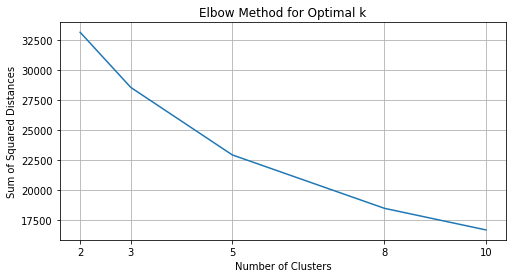

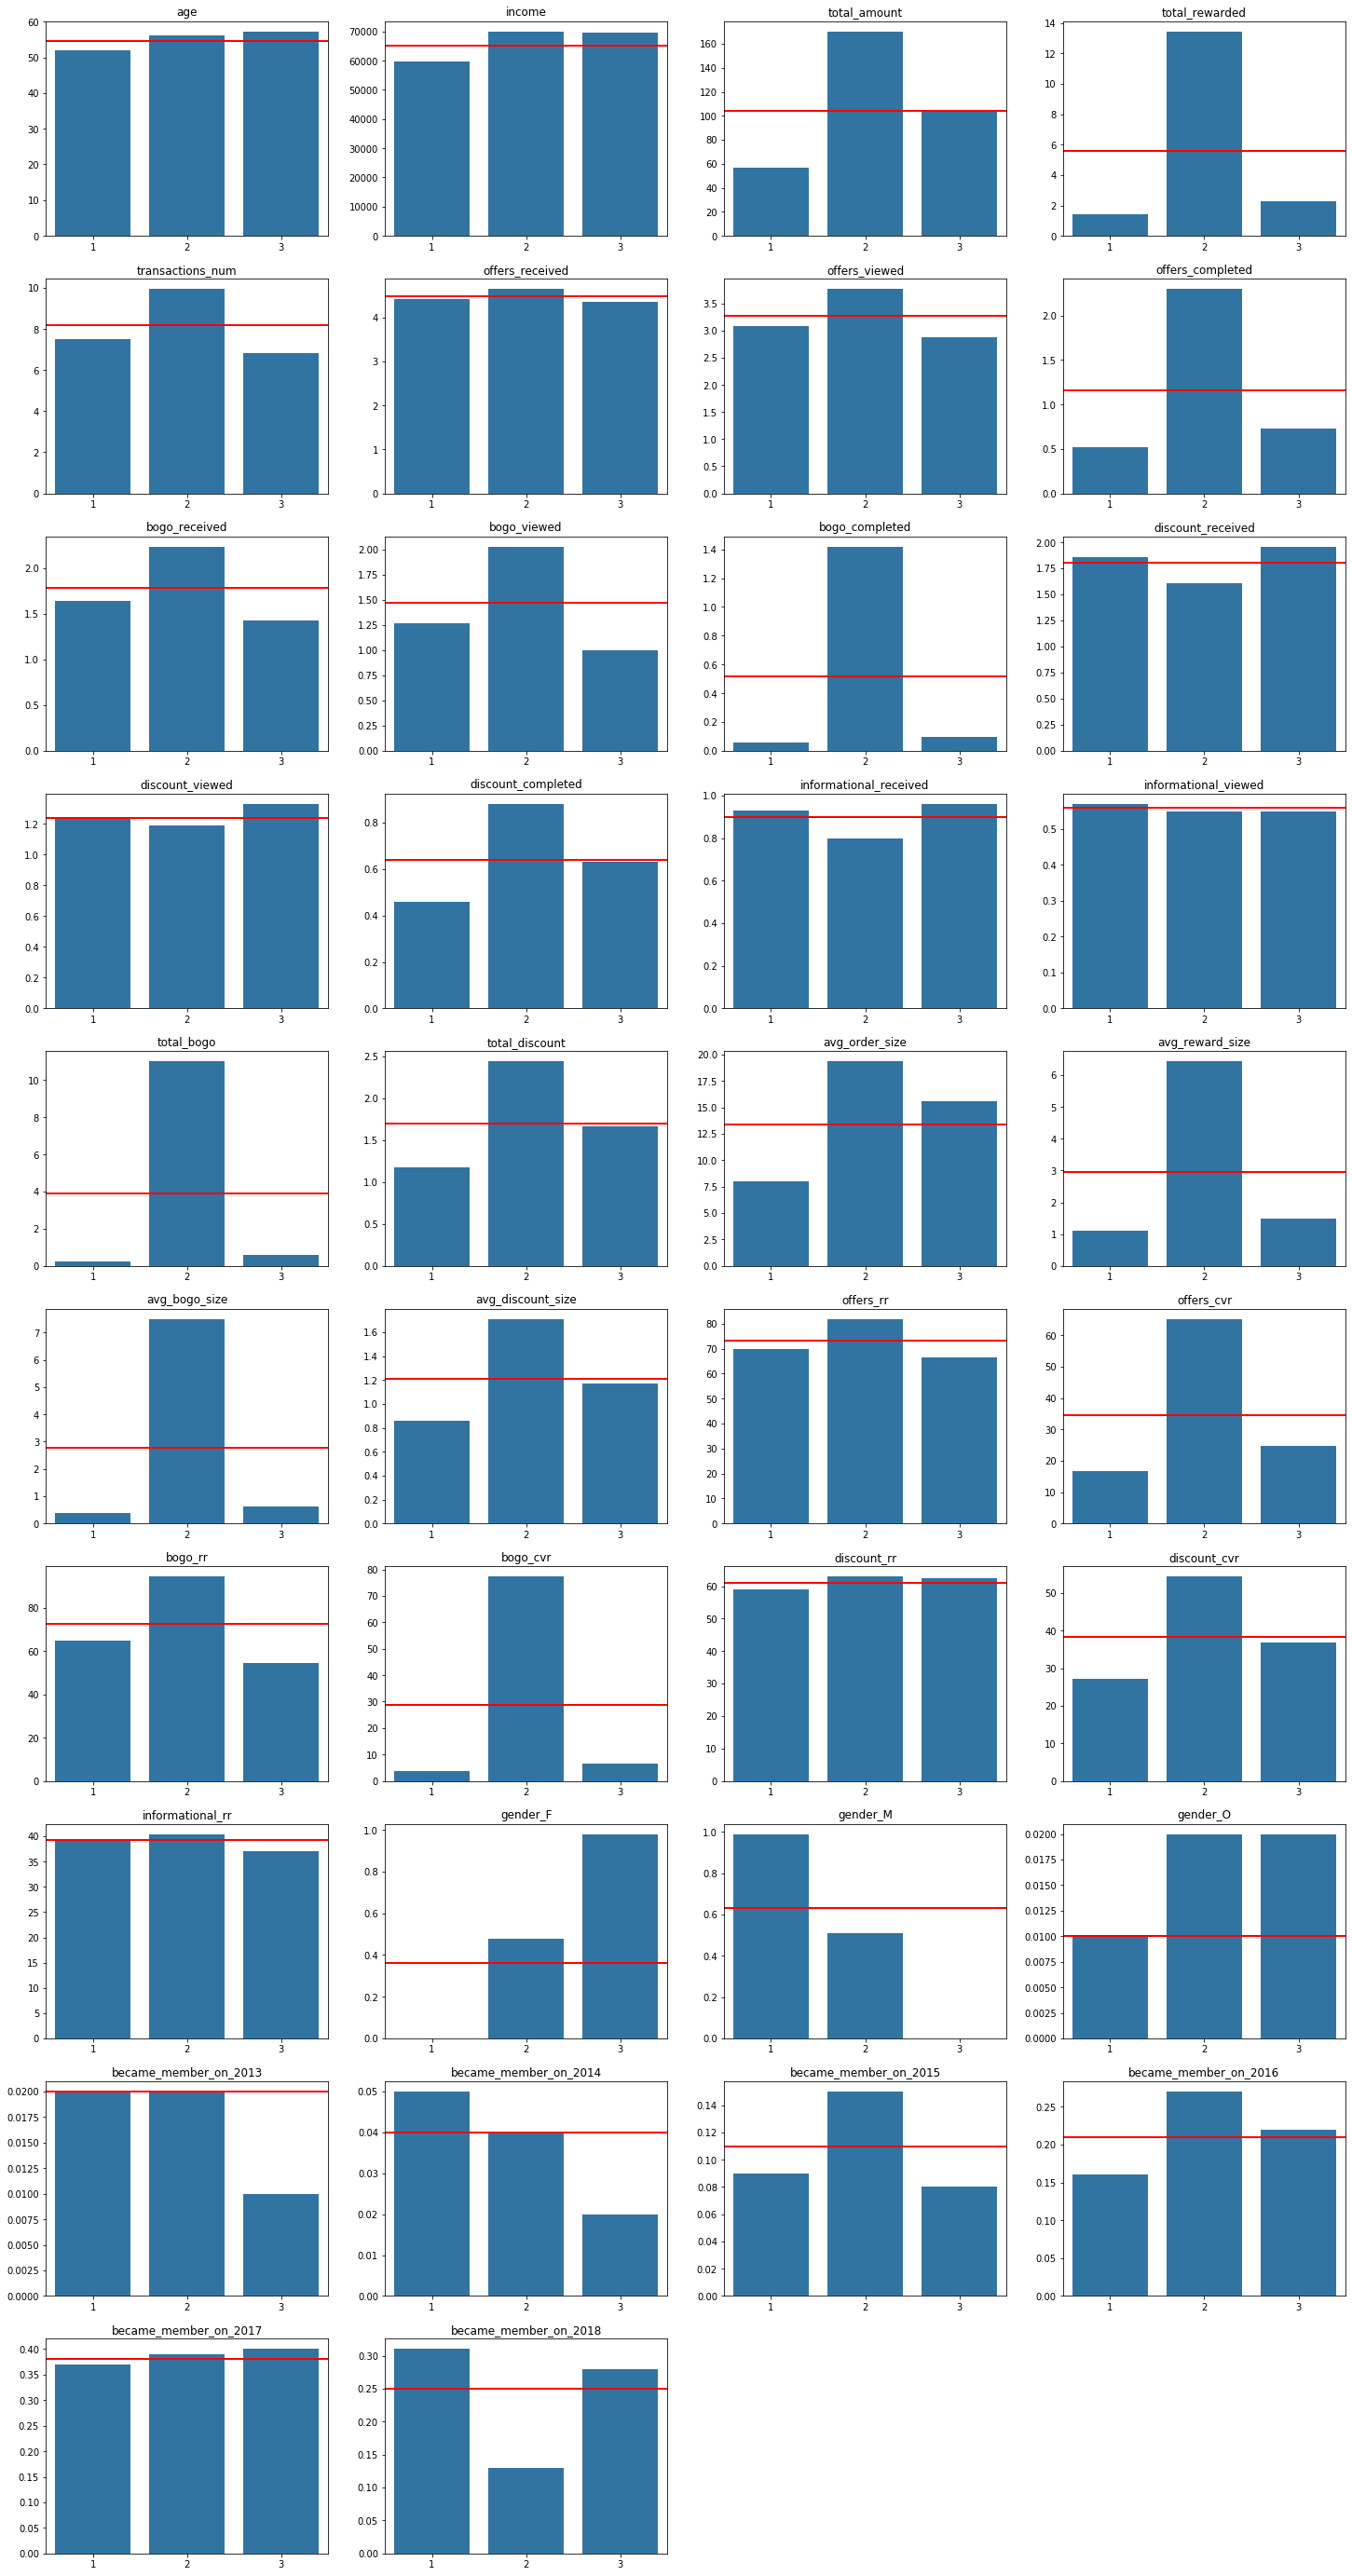

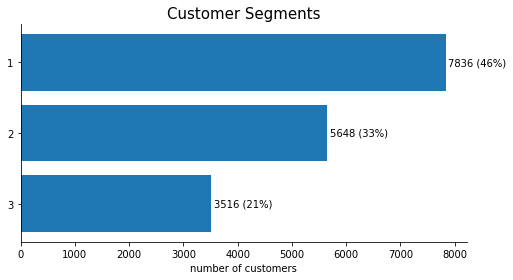

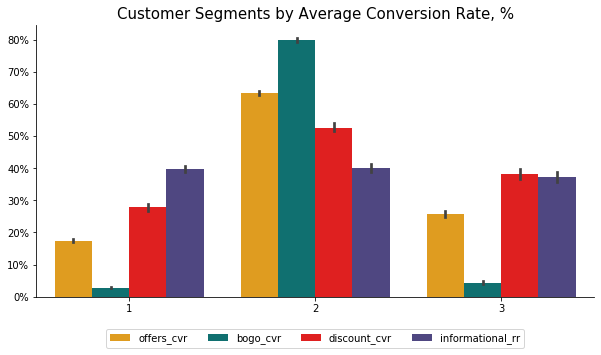

In [20]:
print(80*"*")
print("minmax, pca")
starbucks_predicted1 = create_segments(starbucks_imputed, cluster_num=3, do_minmax=True, do_pca=True)

Note: Based on our metrics, it seems like minmax scale with PCA doesn't really differentiate well.

********************************************************************************
minmax, no pca
silhouette_score: 0.15072713461348725
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.158
   sum of squared distances: 45009.5
3 clusters:
   silouhette score: 0.151
   sum of squared distances: 40354.0
5 clusters:
   silouhette score: 0.136
   sum of squared distances: 35116.1
8 clusters:
   silouhette score: 0.146
   sum of squared distances: 30089.4
10 clusters:
   silouhette score: 0.161
   sum of squared distances: 28174.1
Clustering complete in 0m 18s
--------------------------------------------------------------------------------


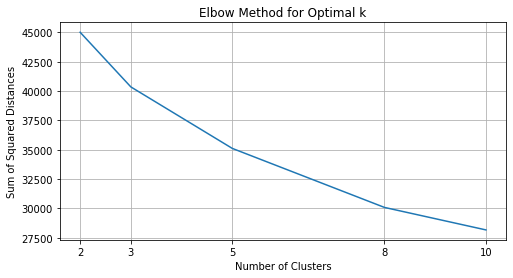

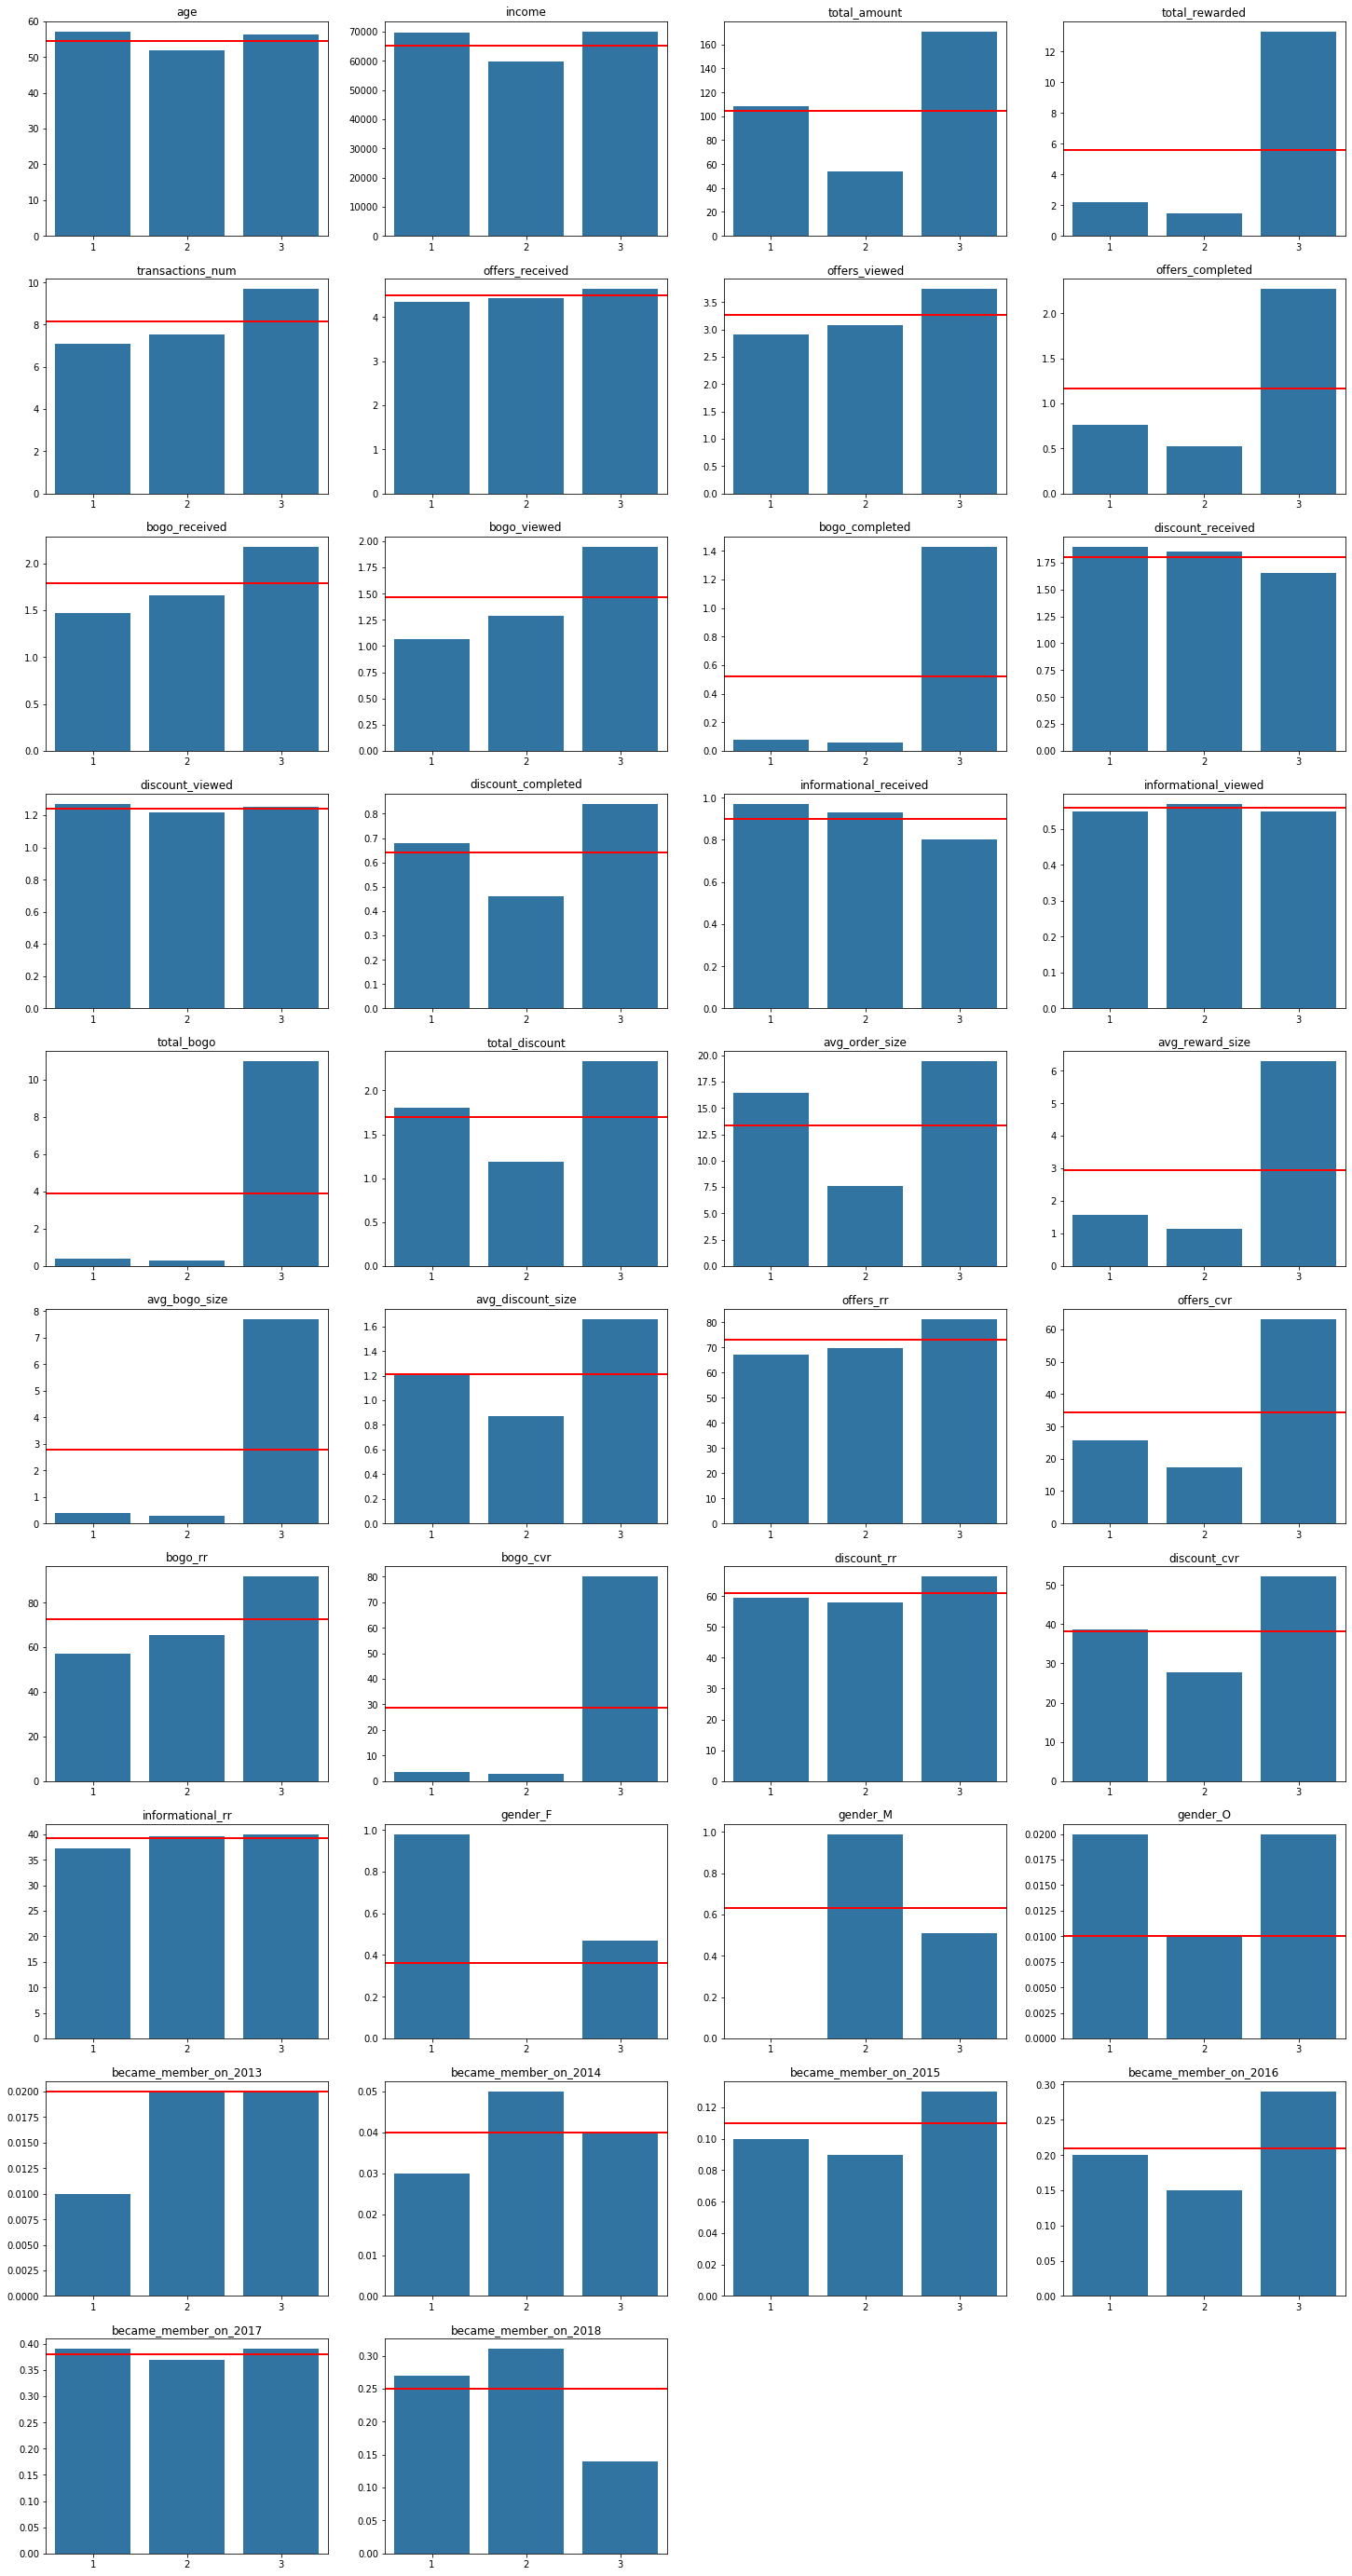

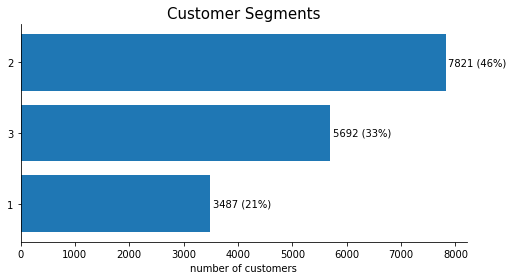

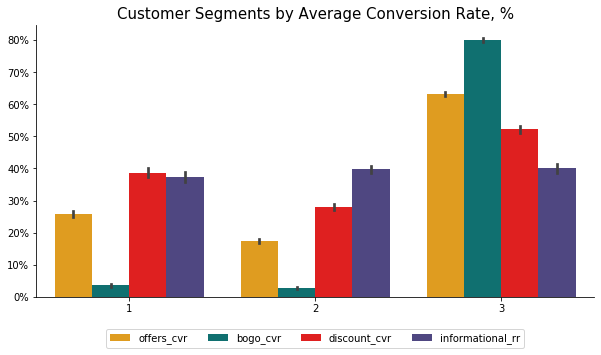

In [21]:
print(80*"*")
print("minmax, no pca")
starbucks_predicted4 = create_segments(starbucks_imputed, cluster_num=3, do_minmax=True, do_pca=False)

Note: the same here - clustering based on minmax sclaer has worse results when judged by our metrics.

********************************************************************************
standard scaler, pca
number of pca components that explain 80%: 11
silhouette_score for 3 clusters: 0.174
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.211
   sum of squared distances: 399897.7
3 clusters:
   silouhette score: 0.174
   sum of squared distances: 348145.9
5 clusters:
   silouhette score: 0.134
   sum of squared distances: 301962.9
8 clusters:
   silouhette score: 0.125
   sum of squared distances: 273380.6
10 clusters:
   silouhette score: 0.114
   sum of squared distances: 260273.6
Clustering complete in 0m 18s
--------------------------------------------------------------------------------


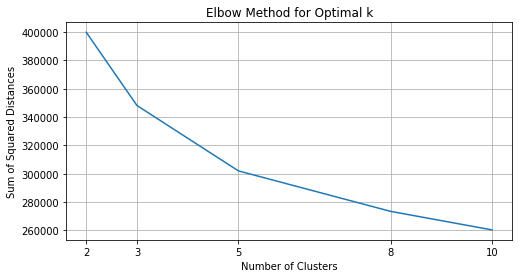

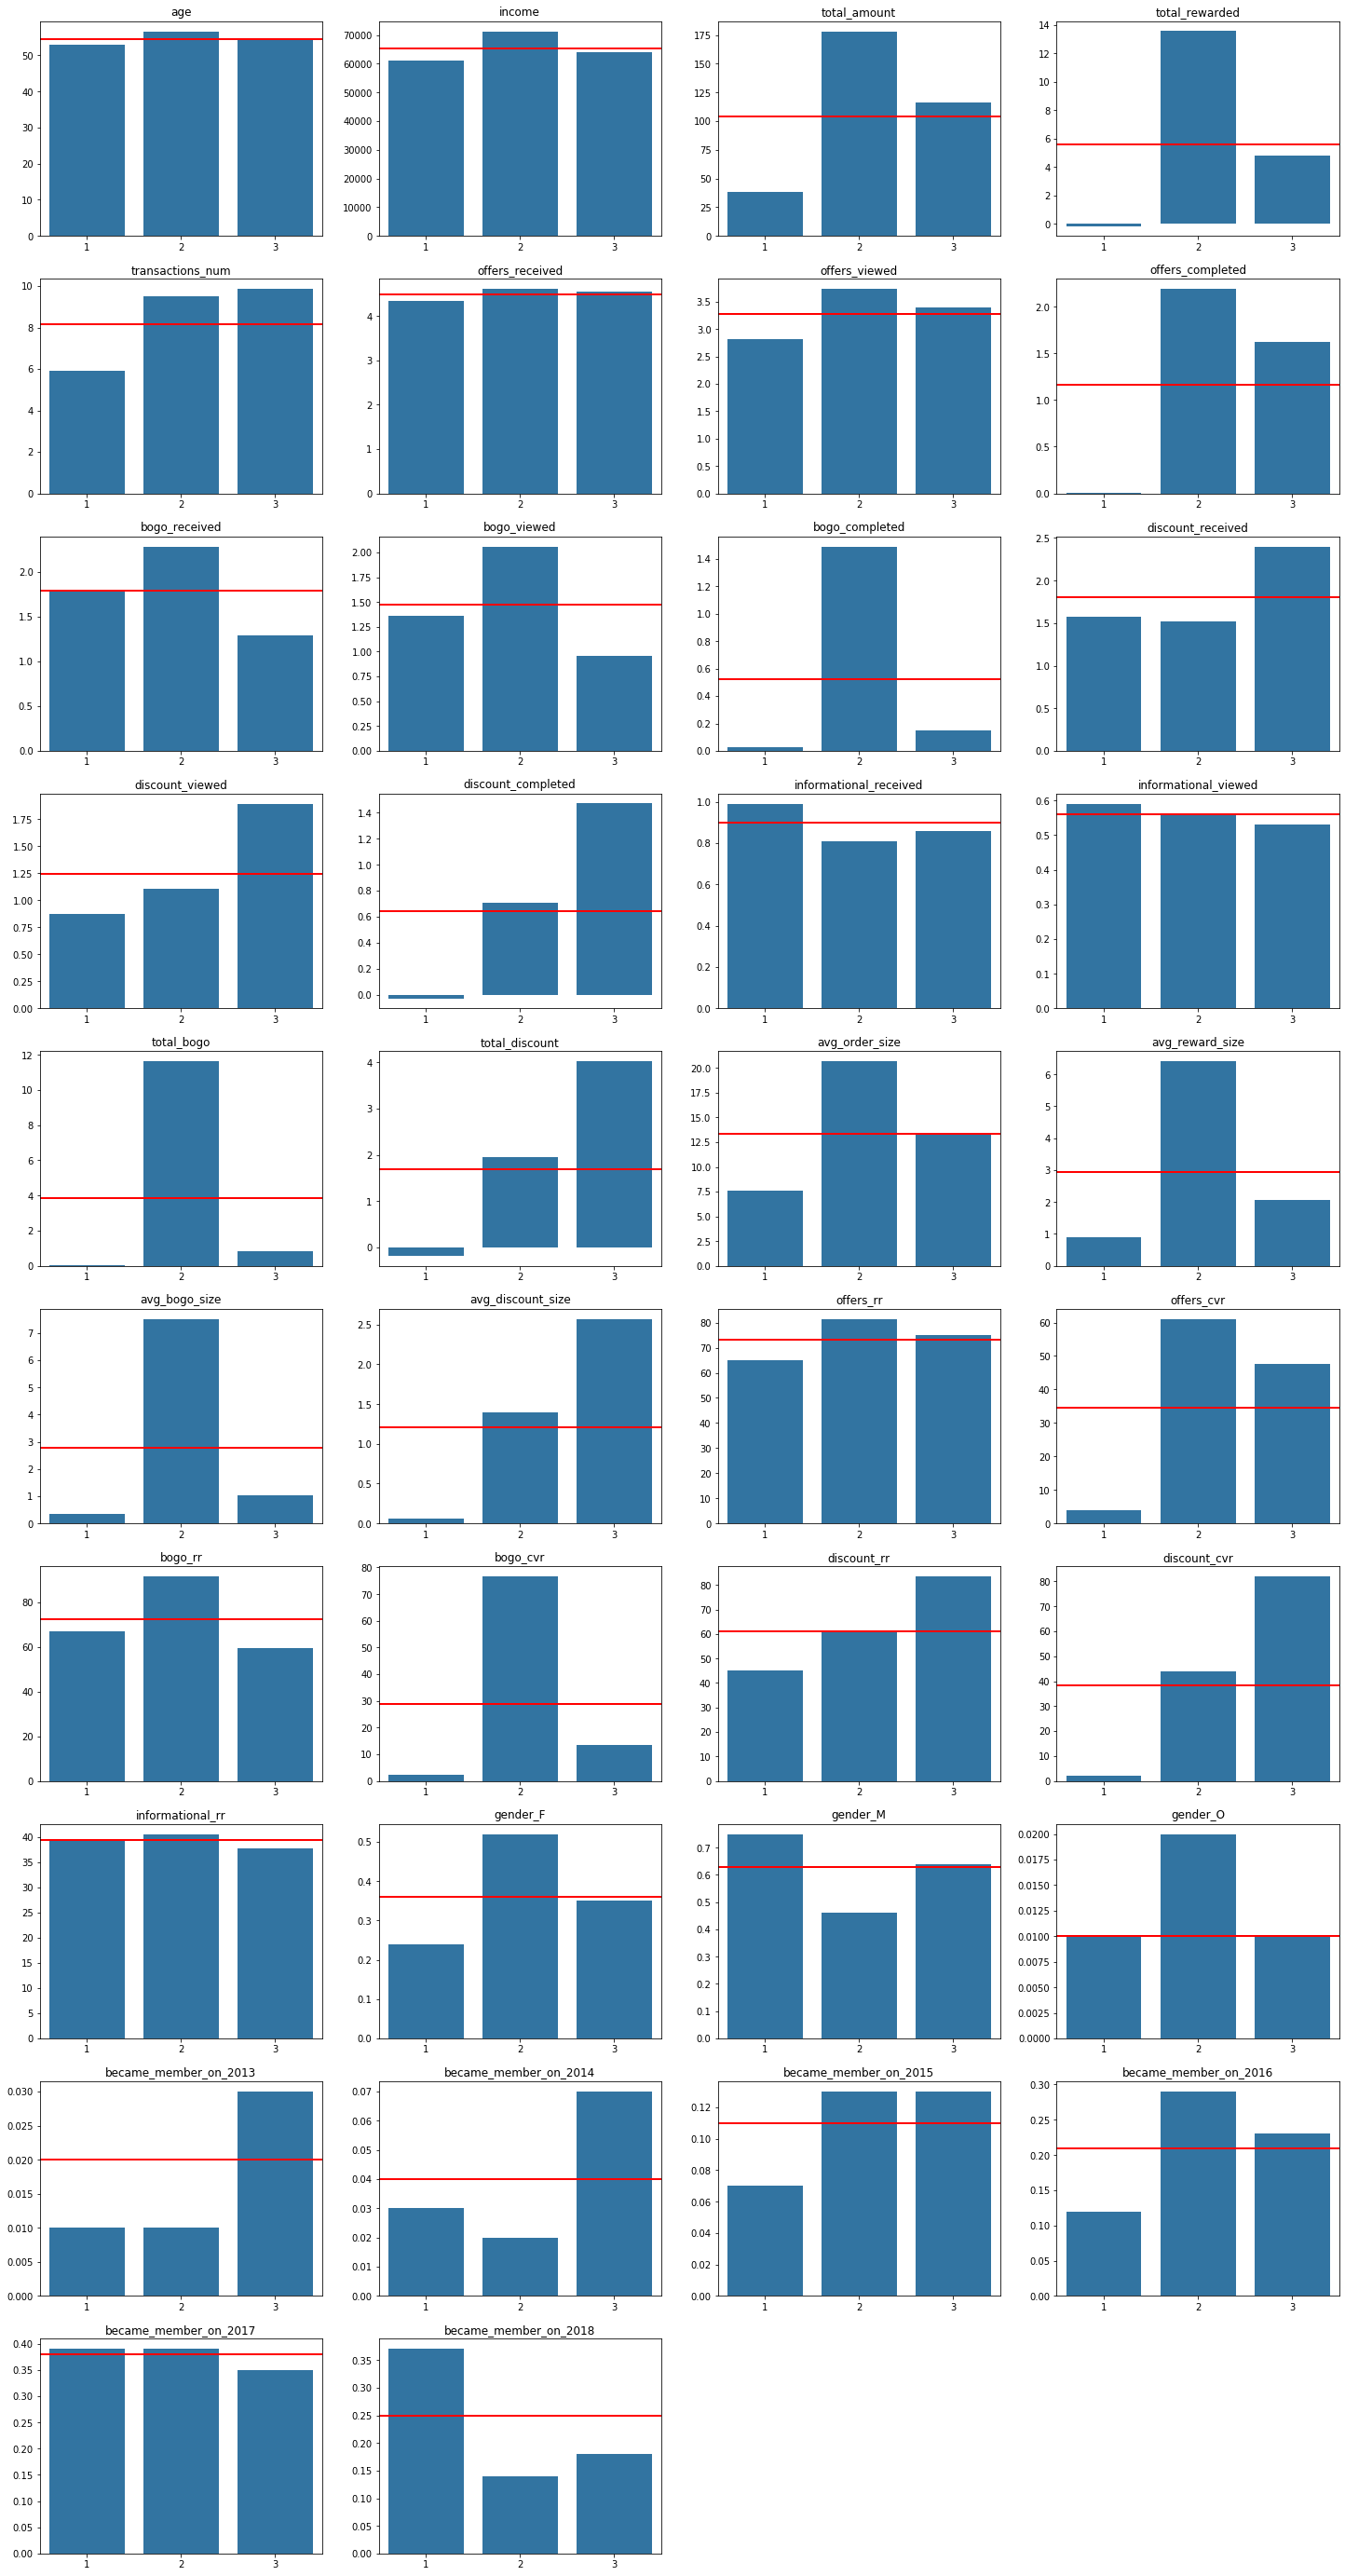

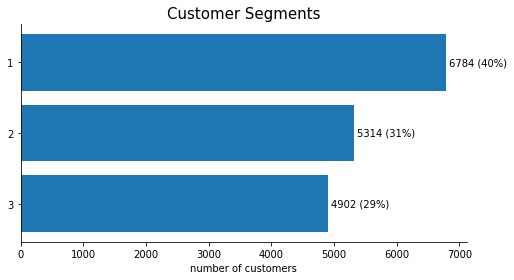

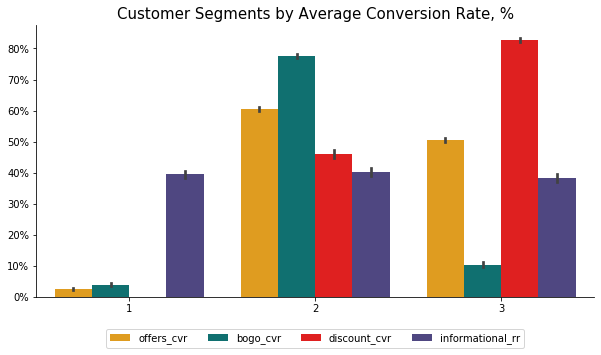

In [22]:
print(80*"*")
print("standard scaler, pca")
starbucks_predicted2 = create_segments(starbucks_imputed, cluster_num=3, do_minmax=False, do_pca=True)

********************************************************************************
standard scaler, no pca
silhouette_score: 0.140239007959436
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.177
   sum of squared distances: 539242.2
3 clusters:
   silouhette score: 0.140
   sum of squared distances: 486546.6
5 clusters:
   silouhette score: 0.102
   sum of squared distances: 437571.4
8 clusters:
   silouhette score: 0.093
   sum of squared distances: 402422.2
10 clusters:
   silouhette score: 0.090
   sum of squared distances: 385689.4
Clustering complete in 0m 20s
--------------------------------------------------------------------------------


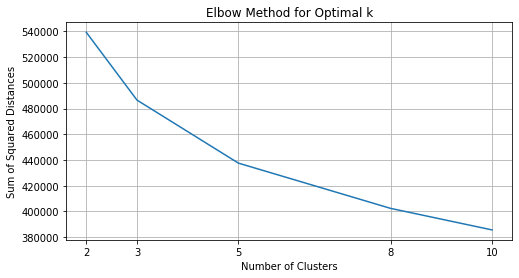

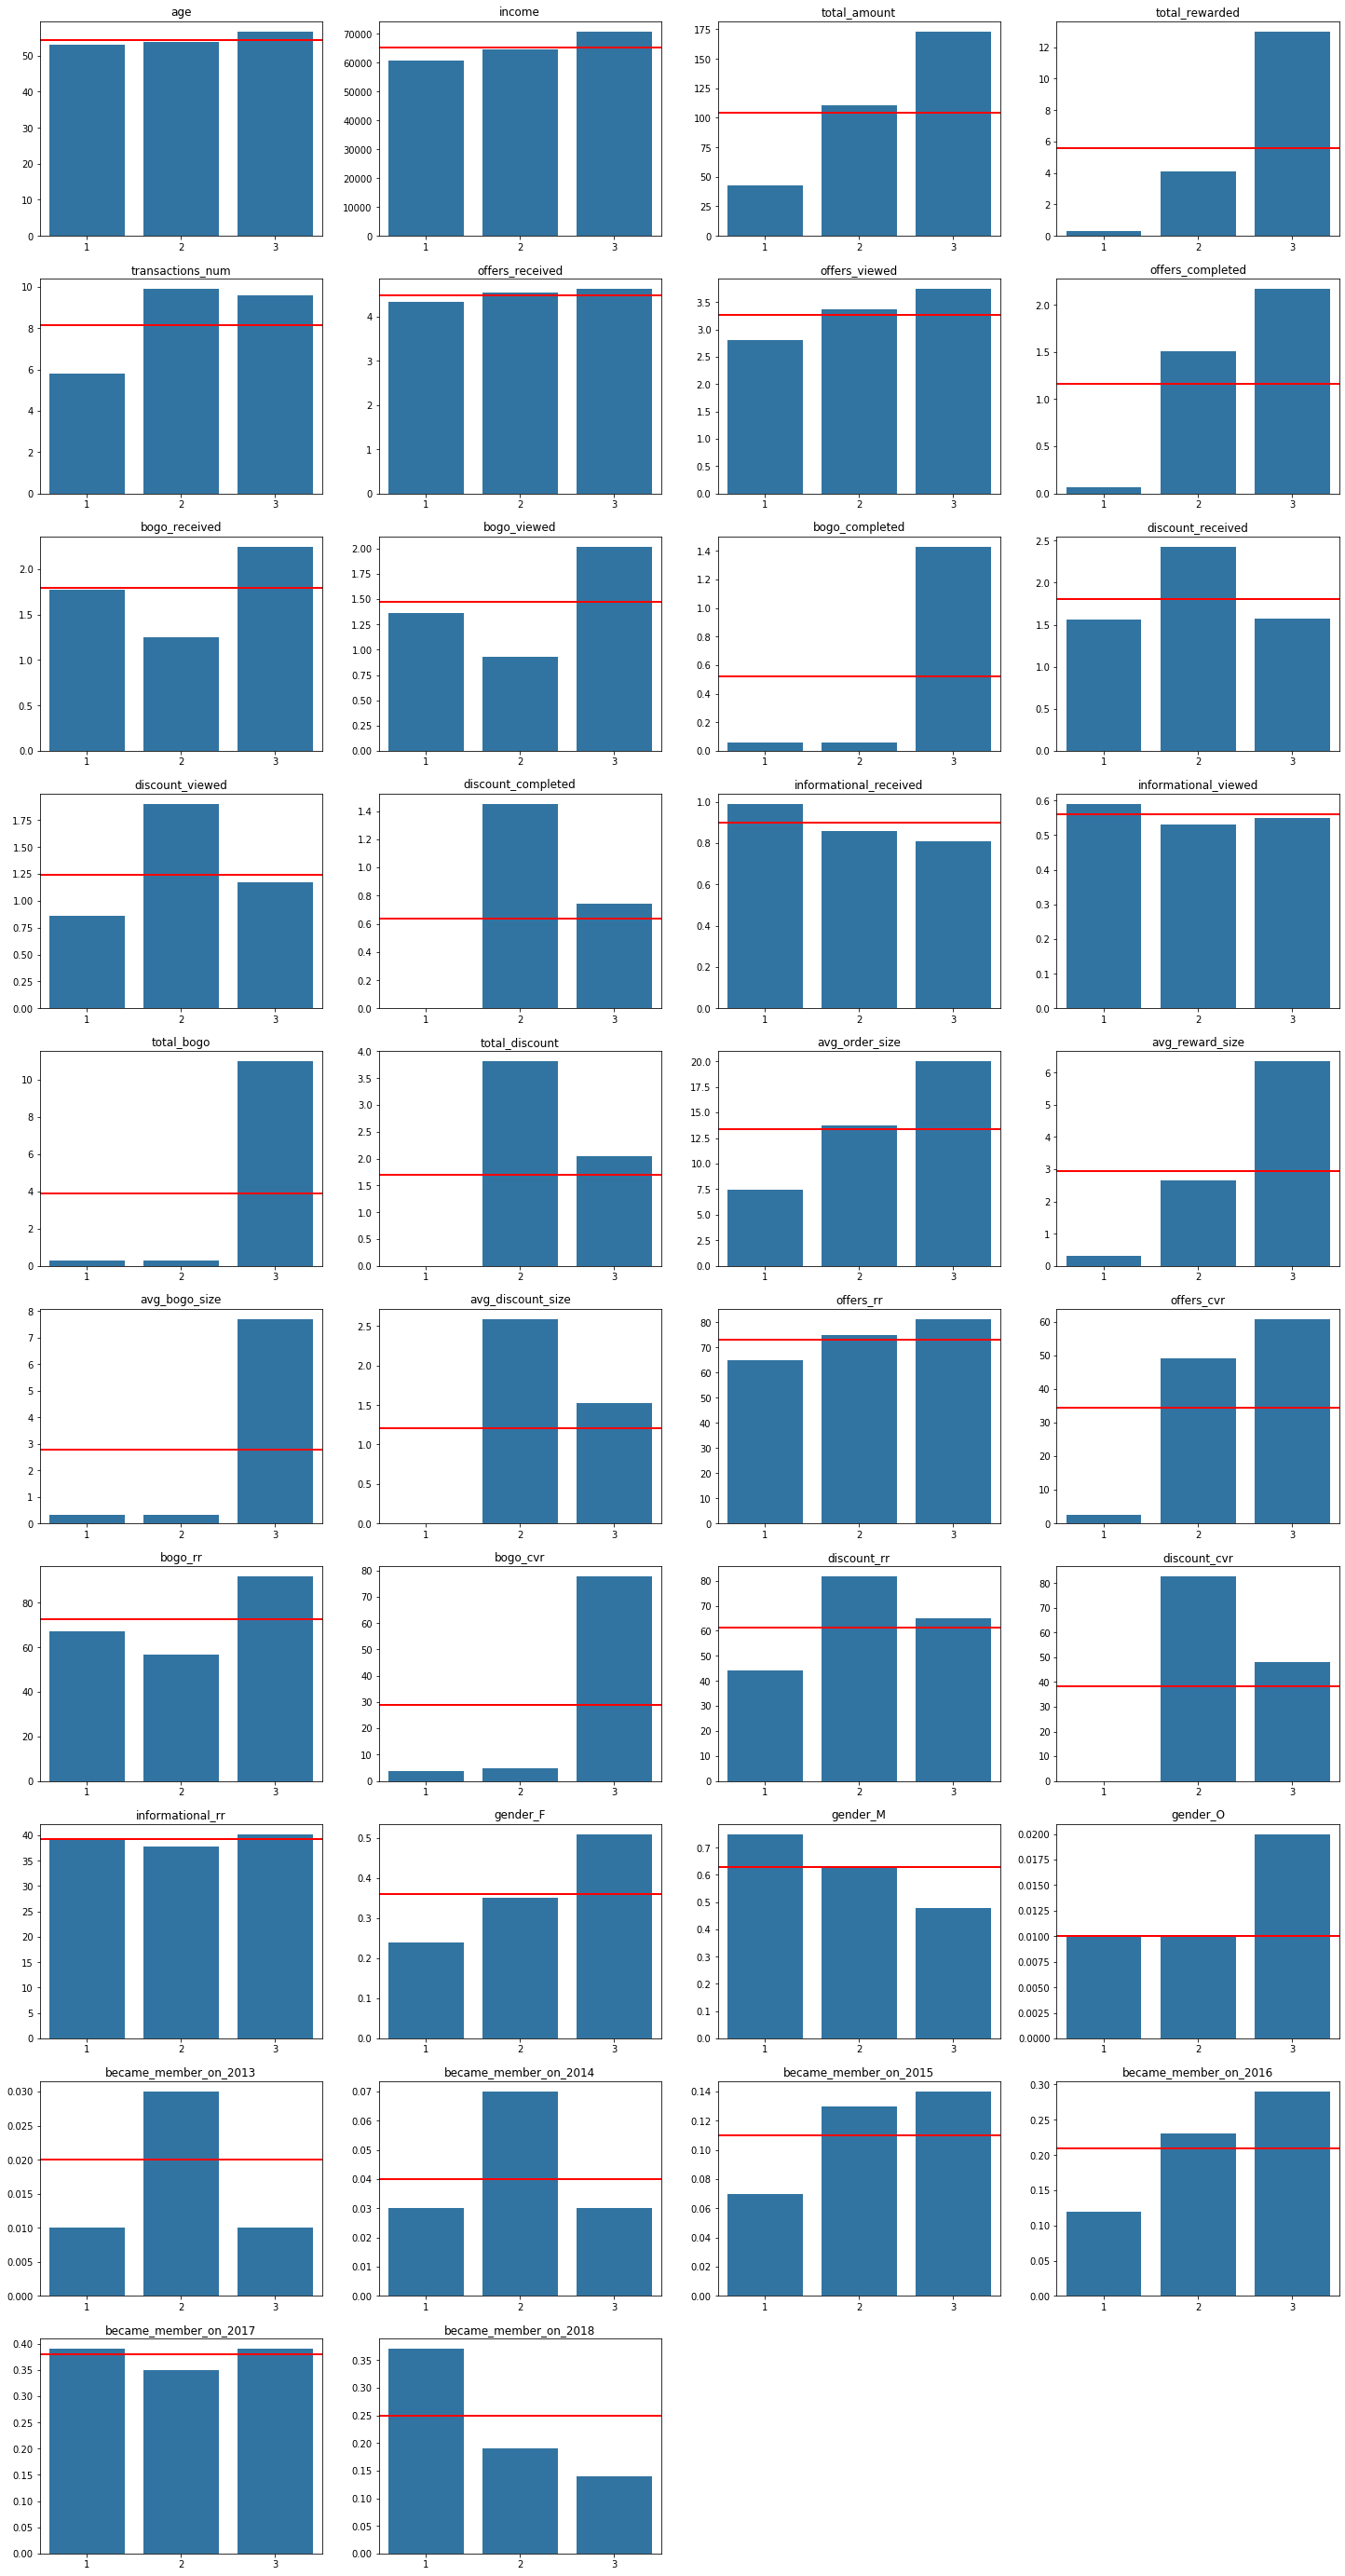

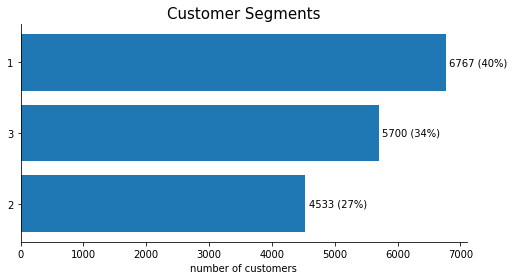

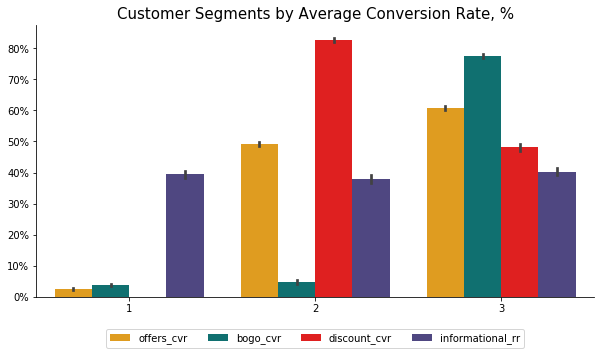

In [23]:
print(80*"*")
print("standard scaler, no pca")
starbucks_predicted3 = create_segments(starbucks_imputed, cluster_num=3, do_minmax=False, do_pca=False)

Checking smaller dataset with less information:

In [28]:
cols = ['gender', 'age', 'person', 'became_member_on', 'income', 'total_amount',
       'total_rewarded', 'transactions_num', 'avg_order_size',
       'total_bogo', 'total_discount', 
       'avg_bogo_size', 'avg_discount_size', 'offers_cvr',
       'bogo_rr', 'bogo_cvr', 'discount_rr', 'discount_cvr',
       'informational_rr']

********************************************************************************
standard scaler, no pca
silhouette_score: 0.152543690568228
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.189
   sum of squared distances: 355052.9
3 clusters:
   silouhette score: 0.153
   sum of squared distances: 319606.9
5 clusters:
   silouhette score: 0.111
   sum of squared distances: 289281.2
8 clusters:
   silouhette score: 0.162
   sum of squared distances: 248147.2
10 clusters:
   silouhette score: 0.136
   sum of squared distances: 227843.5
Clustering complete in 0m 19s
--------------------------------------------------------------------------------


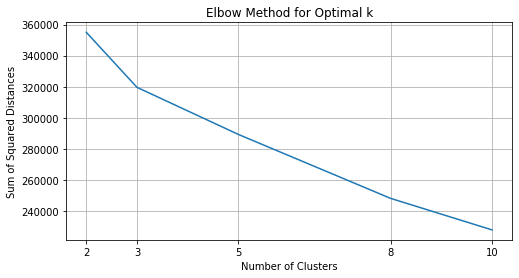

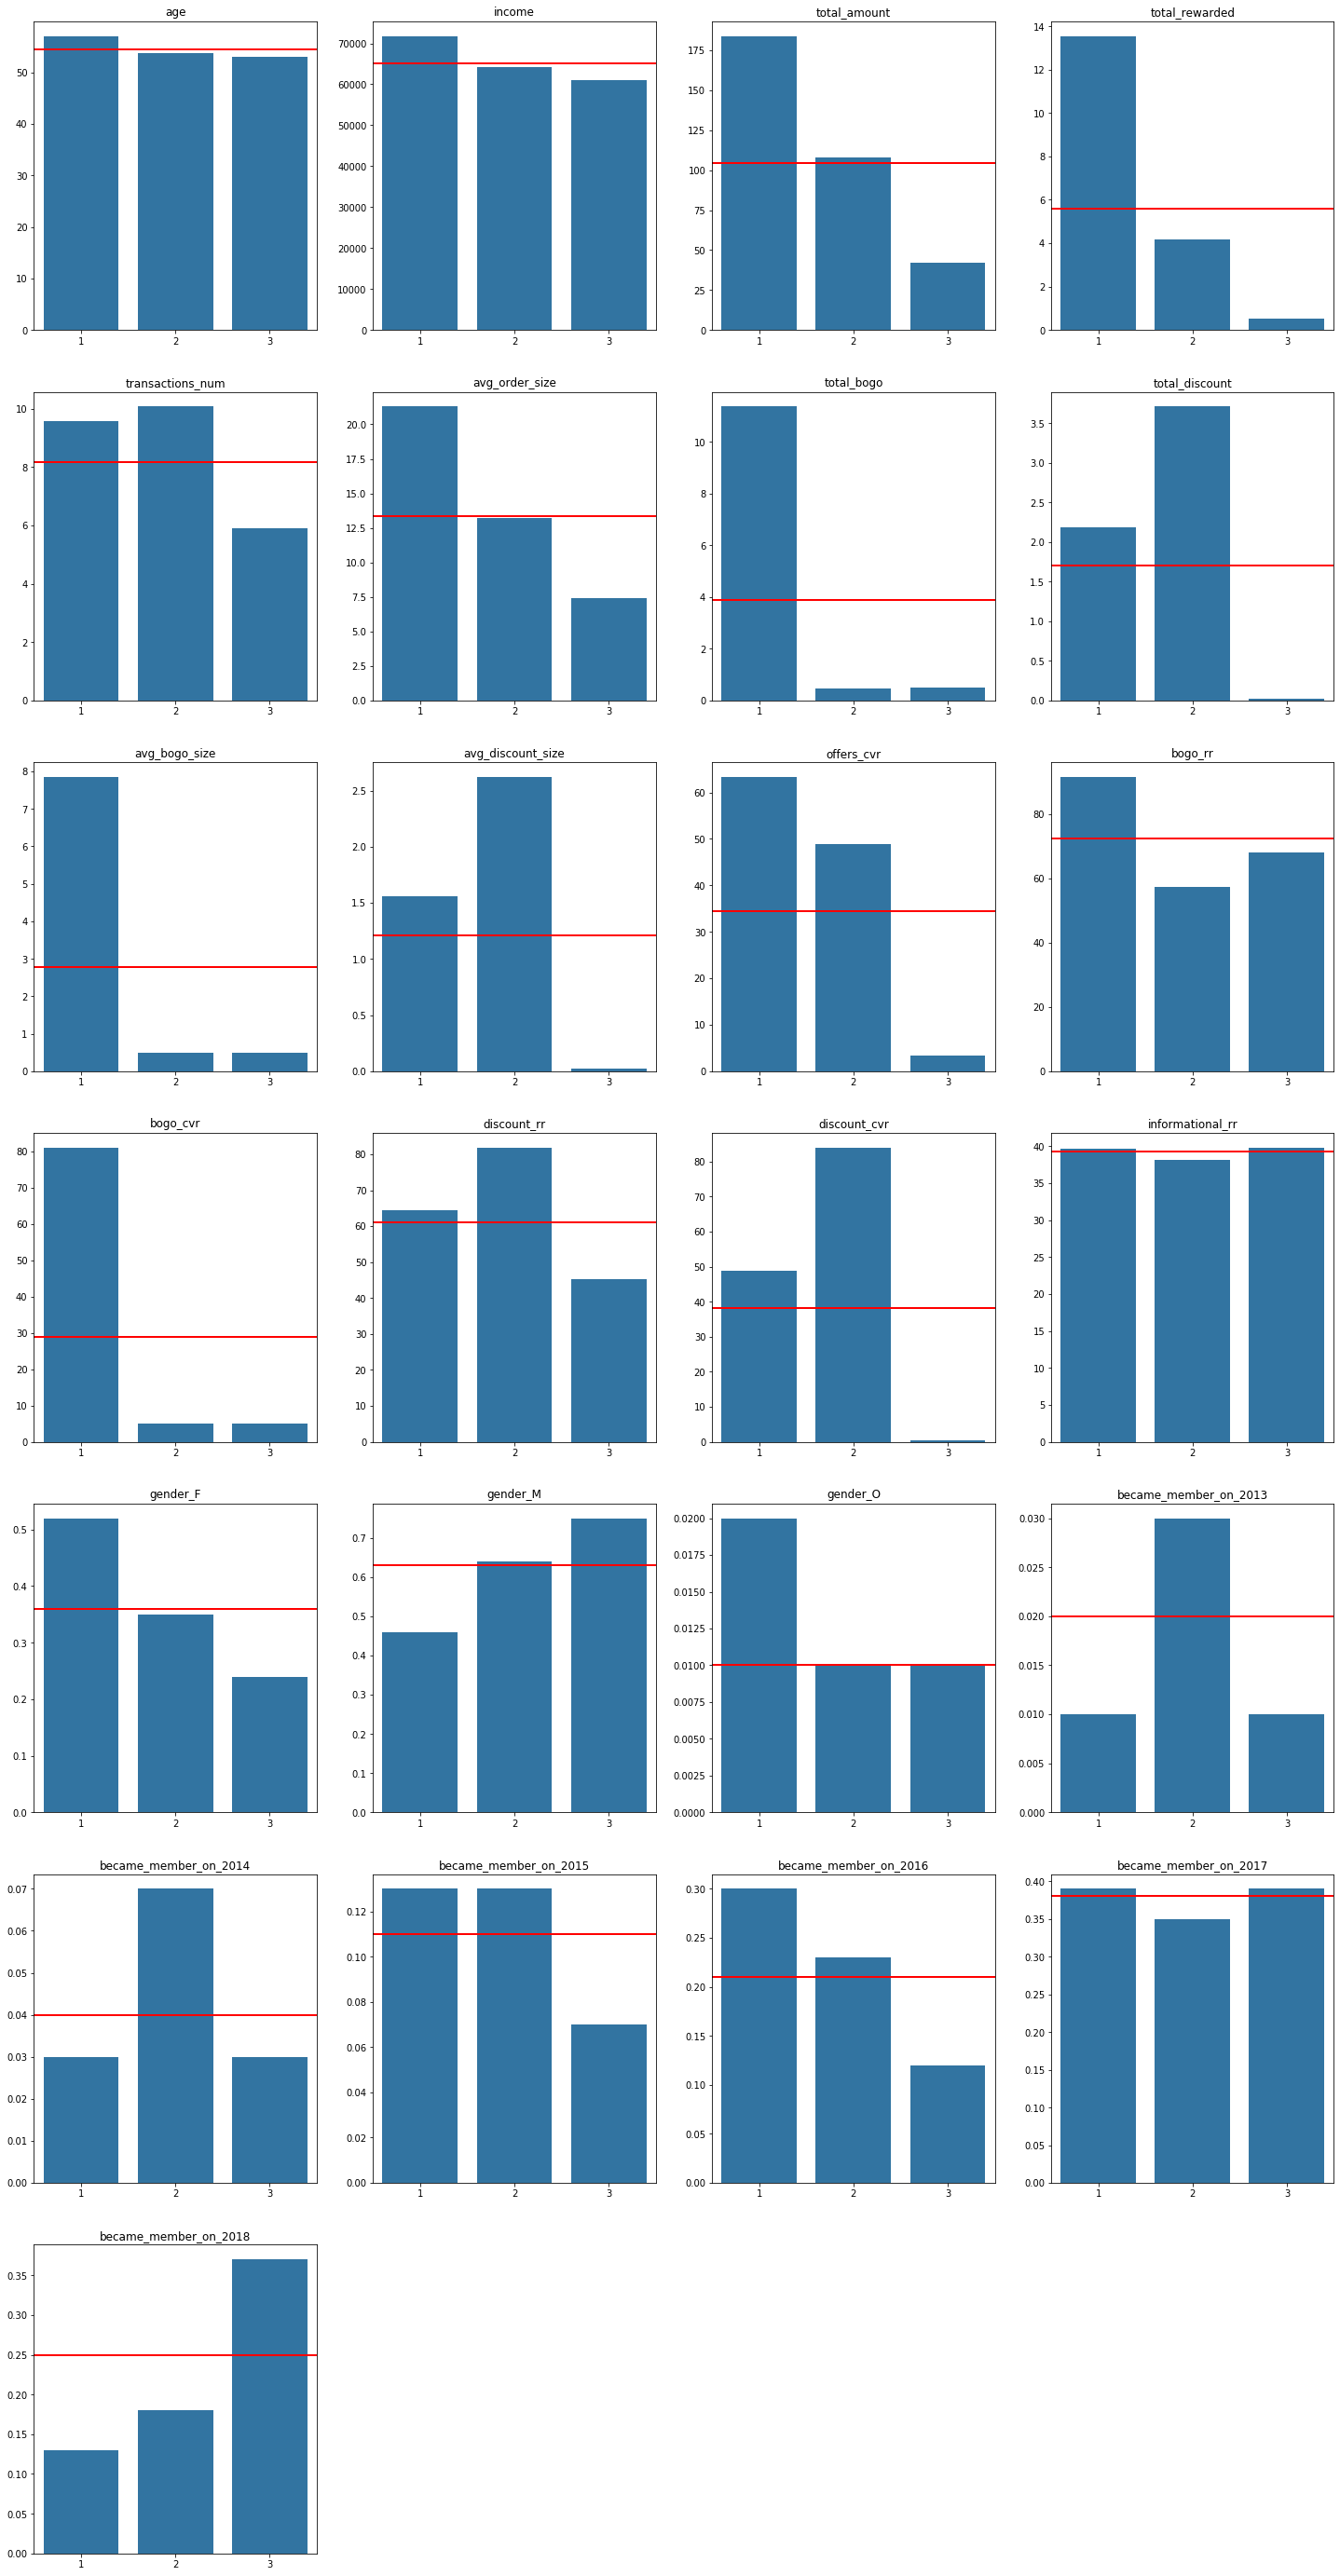

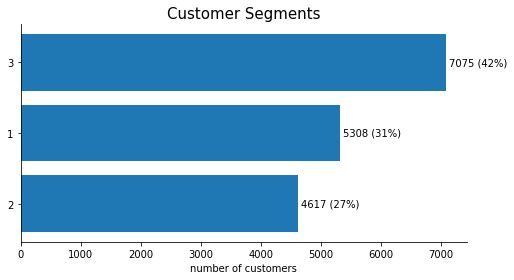

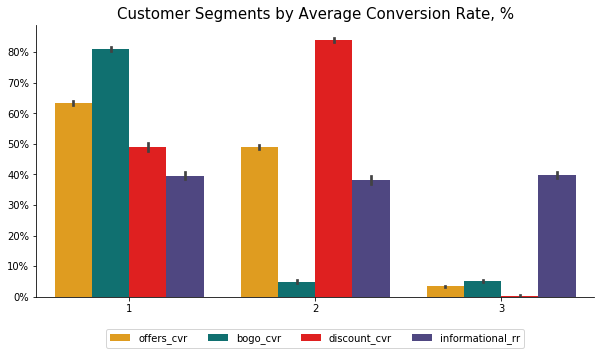

In [29]:
print(80*"*")
print("standard scaler, no pca")
starbucks_predicted3 = create_segments(starbucks_imputed[cols], cluster_num=3, do_minmax=False, do_pca=False)

********************************************************************************
standard scaler, no pca
number of pca components that explain 80%: 10
silhouette_score for 3 clusters: 0.200
__________________________________________________________________________________
2 clusters:
   silouhette score: 0.231
   sum of squared distances: 259452.7
3 clusters:
   silouhette score: 0.200
   sum of squared distances: 224475.6
5 clusters:
   silouhette score: 0.212
   sum of squared distances: 194060.1
8 clusters:
   silouhette score: 0.180
   sum of squared distances: 163337.7
10 clusters:
   silouhette score: 0.198
   sum of squared distances: 147932.6
Clustering complete in 0m 18s
--------------------------------------------------------------------------------


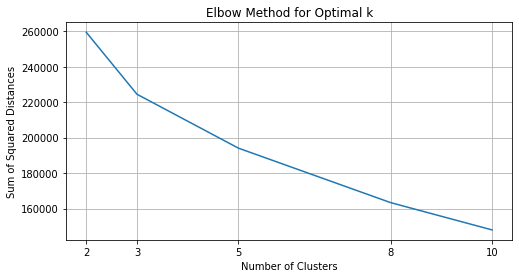

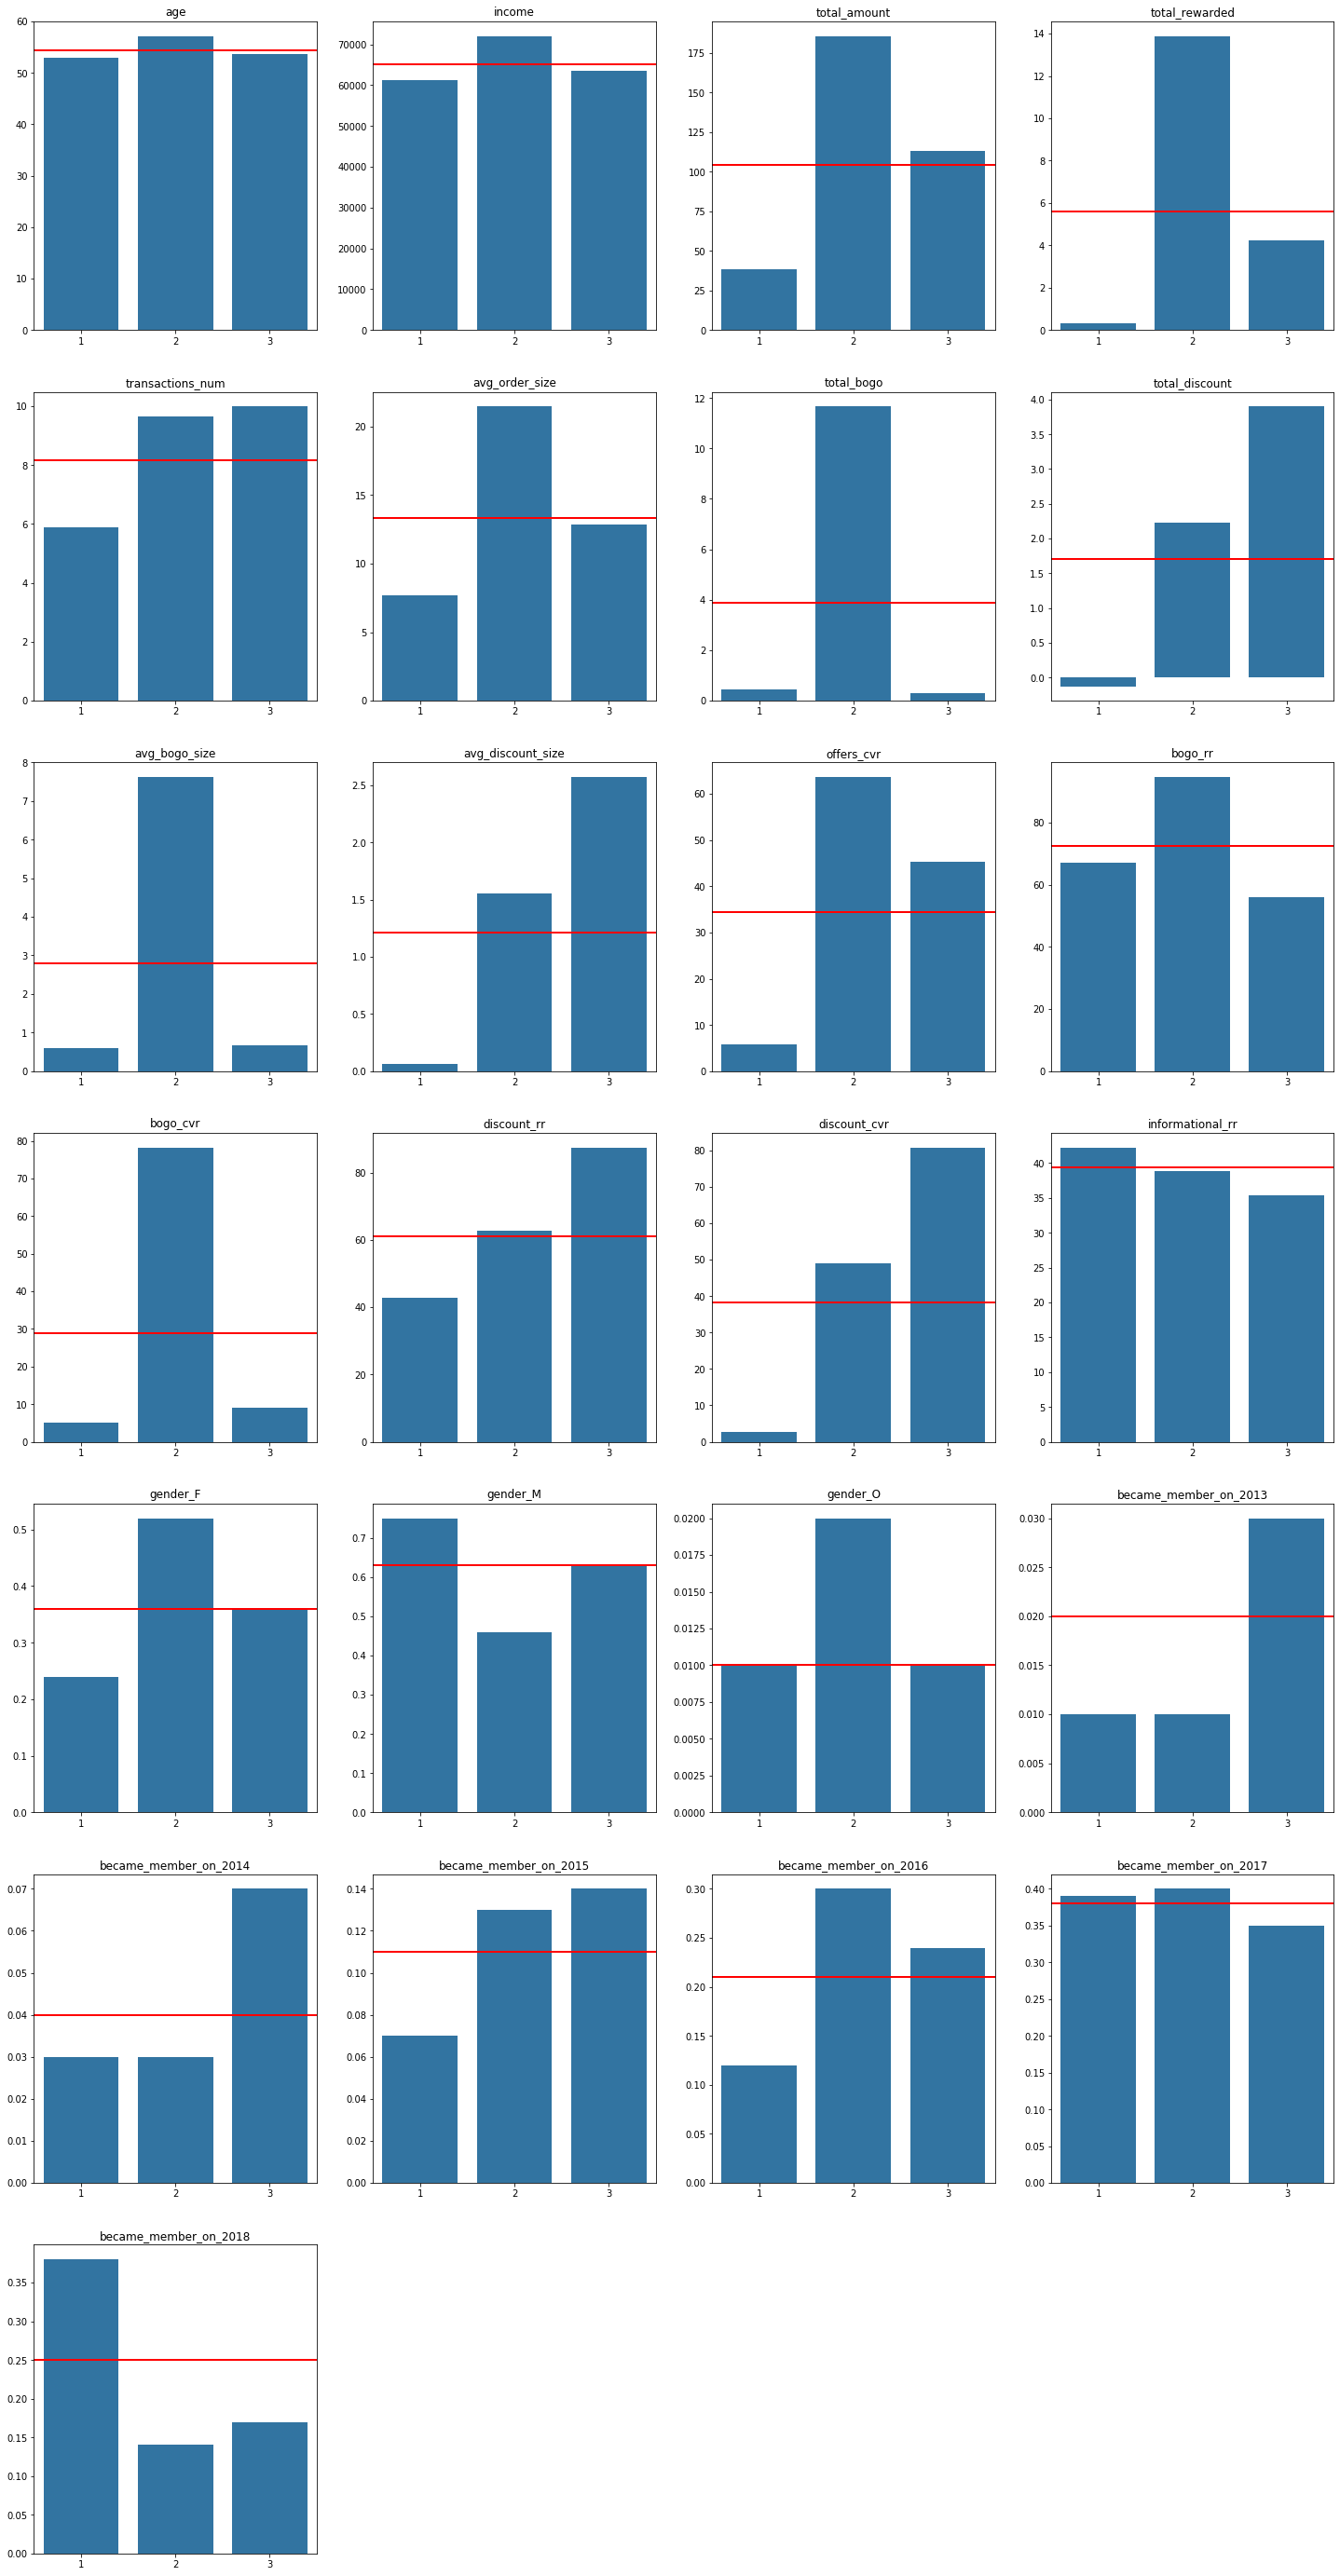

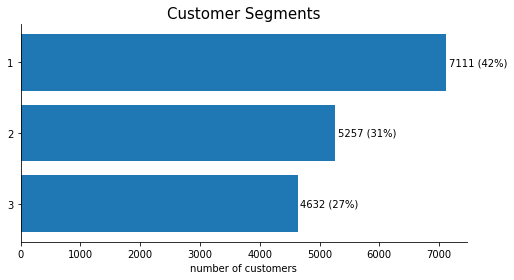

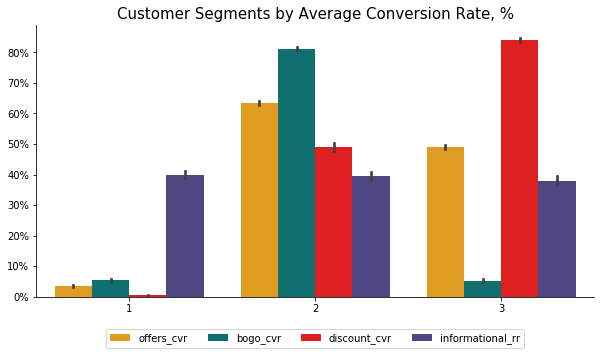

In [30]:
print(80*"*")
print("standard scaler, no pca")
starbucks_predicted3 = create_segments(starbucks_imputed[cols], cluster_num=3, do_minmax=False, do_pca=True)

# Justification:
Here I tested several versions of clustering - with MinMax/Standard Scaler, with/without PCA and on dataset with smaller features. In general, clustering with MinMax Scaler had different results from Standard Scaler, which were not really aligned with the metrics (i.e. differentiated between bogo/discount type worse). This is probably because I have a big number of numerical features with different scales, while MinMax is better suited for categorical features.

In all other cases, the clustering results were good and differed mainly in the cluster sizes. 
As a result, I conclude that the initial decision to use Standard Scaler and perform PCA was correct. 